## STORM: 연구를 위한 멀티 에이전트

### 개요

STORM(Synthesis of Topic Outline through Retrieval and Multi-perspective Question Asking)은 Stanford 대학에서 개발한 LLM 기반의 지식 큐레이션 시스템입니다. 이 시스템은 인터넷 리서치를 통해 Wikipedia 수준의 포괄적이고 체계적인 장문의 기사를 자동으로 생성하는 것을 목표로 합니다.

![](https://github.com/stanford-oval/storm/raw/main/assets/two_stages.jpg)

### 핵심 아키텍처

STORM은 두 단계의 파이프라인으로 구성됩니다:

1. **사전 작성 단계(Pre-writing Stage)**
   - 인터넷 기반 리서치를 수행하여 참고 자료 수집
   - 다양한 관점(perspective) 발견
   - 주제에 대한 개요(outline) 생성

2. **작성 단계(Writing Stage)**
   - 생성된 개요와 수집된 참고 자료를 활용
   - 인용(citation)이 포함된 전체 기사 작성

### 멀티 에이전트 접근법

STORM의 핵심은 **관점 기반 질문 생성(Perspective-Guided Question Asking)** 과 **시뮬레이션된 대화(Simulated Conversation)** 전략입니다:

- **다양한 관점 발견**: 유사한 주제의 기존 기사들을 조사하여 다양한 시각을 발견하고, 이를 질문 생성 과정에 활용
- **역할 기반 대화 시뮬레이션**: Wikipedia 작성자와 주제 전문가 간의 대화를 시뮬레이션
  - 작성자 에이전트: 다양한 관점에서 질문 제기
  - 전문가 에이전트: 인터넷 소스에 기반한 답변 제공
  - 이를 통해 이해도를 업데이트하고 후속 질문 생성

### Co-STORM: 협업 확장

Co-STORM은 STORM을 협업 기능으로 확장한 버전으로, 다음과 같은 멀티 에이전트 구성을 포함합니다:


- **LLM 전문가 에이전트**: 외부 소스에 기반한 답변 생성 및 후속 질문 제기
- **중재자 에이전트(Moderator)**: 발견된 정보에서 영감을 받은 사고를 자극하는 질문 생성
- **동적 마인드맵**: 정보를 계층적으로 정리하여 인간과 시스템 간의 공유 개념 공간 생성

![](https://github.com/stanford-oval/storm/raw/main/assets/co-storm-workflow.jpg)

### 주요 특징

- **포괄적 커버리지**: 다양한 관점에서 주제를 탐색하여 Wikipedia 수준의 광범위한 내용 생성
- **구조화된 정보**: 자동으로 생성된 개요를 통해 체계적으로 정보 조직
- **신뢰할 수 있는 출처**: 인터넷 소스에 기반하여 모든 정보에 인용 포함
- **평가 검증**: FreshWiki 데이터셋을 통한 평가에서 기존 방법 대비 조직성 25%, 커버리지 10% 향상

STORM은 복잡한 연구 작업을 자동화하고, 다양한 관점에서 정보를 종합하며, 신뢰할 수 있는 장문의 리포트를 생성하는 멀티 에이전트 시스템의 우수한 사례입니다.

---

- 참고 자료: https://wikidocs.net/270693
- 관련 논문: https://arxiv.org/abs/2402.14207
- GitHub 저장소: https://github.com/stanford-oval/storm

## 환경 설정

In [2]:
import os
import getpass
from dotenv import load_dotenv

load_dotenv("../.env", override=True)


def _set_env(var: str):
    env_value = os.environ.get(var)
    if not env_value:
        env_value = getpass.getpass(f"{var}: ")

    os.environ[var] = env_value


_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"
_set_env("OPENAI_API_KEY")

## 분석가 생성 에이전트 with Human-In-The-Loop

분석가 생성이 필요한 클래스를 정의합니다.

In [3]:
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field


class Analyst(BaseModel):
    """분석가 속성과 메타데이터를 정의"""

    affiliation: Annotated[str, Field(description="분석가의 주요 소속 기관")]
    name: Annotated[str, Field(description="분석가 이름")]
    role: Annotated[str, Field(description="주제 맥락에서의 분석가의 역할")]
    description: Annotated[
        str, Field(description="분석가의 관심사, 우려 사항 및 동기 설명")
    ]

    @property
    def persona(self) -> str:
        return (
            f"이름: {self.name}\n"
            f"역할: {self.role}\n"
            f"소속 기관: {self.affiliation}\n"
            f"설명: {self.description}\n"
        )


class Perspectives(BaseModel):
    """분석가들의 집합"""

    analysts: Annotated[
        list[Analyst],
        Field(description="분석가들의 역할 및 소속 기관을 포함한 종합 목록"),
    ]


### 분석가 생성 상태 및 노드 정의

In [4]:
# 상태 정의
class GenerateAnalystsState(TypedDict):
    topic: Annotated[str, "연구 주제"]
    max_analysts: Annotated[int, "생성할 분석가의 최대 수"]
    human_analyst_feedback: Annotated[str, "휴먼 피드백"]
    analysts: Annotated[list[Analyst], "분석가 목록"]

In [5]:
# 분석가 생성 프롬프트
analyst_instructions = """AI 애널리스트 페르소나 세트를 생성하는 임무를 맡았습니다.

다음 지침을 주의 깊게 따르십시오:

1. 먼저 연구 주제를 검토하십시오:

{topic}

2. 애널리스트 생성 가이드로 제공된 선택적 편집 피드백을 검토하십시오:

{human_analyst_feedback}

3. 위 문서 및/또는 피드백을 바탕으로 가장 흥미로운 테마를 결정하십시오.

4. 상위 {max_analysts}개 테마를 선정하십시오.

5. 각 테마에 한 명의 애널리스트를 배정하십시오."""

In [6]:
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage


llm = init_chat_model("openai:gpt-4.1-mini")


# 분석가 생성 노드
def create_analysts(state: GenerateAnalystsState):
    """분석가 페르소나를 생성합니다."""

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback = state.get("human_analyst_feedback", "")

    llm_with_structured = llm.with_structured_output(Perspectives)

    system_message = analyst_instructions.format(
        topic=topic,
        human_analyst_feedback=human_analyst_feedback,
        max_analysts=max_analysts,
    )

    response = llm_with_structured.invoke(
        [SystemMessage(content=system_message)]
        + [HumanMessage(content="Generate the set of analysts.")]
    )

    return {
        "analysts": response.analysts,
    }

In [7]:
create_analysts({"topic": "멀티 에이전트", "max_analysts": 3})

{'analysts': [Analyst(affiliation='MIT Computer Science and Artificial Intelligence Laboratory (CSAIL)', name='Dr. Lina Chen', role='Multi-Agent System Architect', description='Expert in decentralized decision-making and coordination in large-scale multi-agent systems, focusing on scalable algorithms and real-time interaction models.'),
  Analyst(affiliation='Stanford University, Department of Computer Science', name='Prof. Javier Morales', role='AI and Game Theory Researcher', description='Specializes in strategic behavior modeling in multi-agent environments, including negotiation, cooperation, and competitive dynamics among autonomous agents.'),
  Analyst(affiliation='OpenAI Research', name='Dr. Aisha Kapoor', role='Reinforcement Learning Scientist', description='Focuses on advanced reinforcement learning techniques for multi-agent collaboration, adaptive strategy development, and emergent behavior analysis.')]}

In [8]:
# 사용자 피드백 노드
def human_feedback(state: GenerateAnalystsState):
    """사용자 피드백을 받기 위한 중단점 노드"""
    pass

### 분석가 생성 그래프 작성

In [ ]:
from typing import Literal
from langgraph.graph import StateGraph, END
from langgraph.checkpoint.memory import InMemorySaver


def should_continue(state: GenerateAnalystsState) -> Literal["create_analysts", END]:
    """워크플로우의 다음 노드를 결정합니다."""

    human_analyst_feedback = state.get("human_analyst_feedback", "")
    if human_analyst_feedback:
        return "create_analysts"
    return END


builder = StateGraph(GenerateAnalystsState)
builder.add_node(create_analysts)
builder.add_node(human_feedback)

builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges(
    "human_feedback", should_continue, {"create_analysts": "create_analysts", END: END}
)
builder.set_entry_point("create_analysts")
graph = builder.compile(
    interrupt_before=["human_feedback"], checkpointer=InMemorySaver()
)


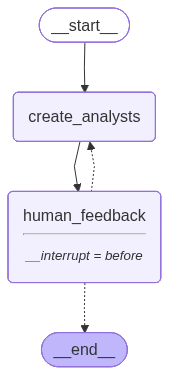

In [10]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

### 분석가 생성 그래프 실행

In [ ]:
from pprint import pprint
from random import random
from langchain_core.runnables.config import RunnableConfig

config = RunnableConfig(configurable={"thread_id": random()})

inputs = {
    "max_analysts": 3,
    "topic": "Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?",
}
for event in graph.stream(inputs, config=config):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)



##### create_analysts #####
{'analysts': [Analyst(affiliation='AI Research Institute', name='Dr. Mina Lee', role='Comparative Analyst', description='Dr. Lee specializes in evaluating different retrieval-augmented generation (RAG) systems. She focuses on dissecting the technical and functional differences between Agentic RAG and Adaptive RAG to clarify their unique capabilities and applications.'),
              Analyst(affiliation='Tech Innovators Consulting', name='Mr. Jun Park', role='Adaptive Systems Expert', description='Mr. Park has extensive experience in adaptive machine learning architectures. He analyzes how Adaptive RAG systems dynamically adjust retrieval and generation processes based on context and user interaction patterns.'),
              Analyst(affiliation='NextGen AI Labs', name='Dr. Soo Kim', role='Agentic AI Specialist', description='Dr. Kim researches agentic AI frameworks that incorporate autonomous decision-making in retrieval-augmented generation. He provides 

In [12]:
# 현재 상태 스냅샷
snapshot = graph.get_state(config)
pprint(snapshot.values)
pprint(snapshot.next)

{'analysts': [Analyst(affiliation='AI Research Institute', name='Dr. Mina Lee', role='Comparative Analyst', description='Dr. Lee specializes in evaluating different retrieval-augmented generation (RAG) systems. She focuses on dissecting the technical and functional differences between Agentic RAG and Adaptive RAG to clarify their unique capabilities and applications.'),
              Analyst(affiliation='Tech Innovators Consulting', name='Mr. Jun Park', role='Adaptive Systems Expert', description='Mr. Park has extensive experience in adaptive machine learning architectures. He analyzes how Adaptive RAG systems dynamically adjust retrieval and generation processes based on context and user interaction patterns.'),
              Analyst(affiliation='NextGen AI Labs', name='Dr. Soo Kim', role='Agentic AI Specialist', description='Dr. Kim researches agentic AI frameworks that incorporate autonomous decision-making in retrieval-augmented generation. He provides insight into how Agentic RAG 

In [ ]:
# 휴먼 피드백 전달
from langgraph.types import Command

for event in graph.stream(
    Command(
        update={
            "human_analyst_feedback": "스타트업 출신의 석호필이라는 인물을 추가해 기업가적 관점을 더해주세요."
        },
    ),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None

##### create_analysts #####
{'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Seokho Pil', role='Entrepreneurial Analyst', description='Startup-founder turned analyst focusing on entrepreneurial and business model innovations. Provides insight into adaptive systems from a startup perspective, emphasizing flexibility and market adaptation.'),
              Analyst(affiliation='AI Research Labs', name='Dr. Minji Kim', role='Agentic RAG Specialist', description='Expert in retrieval-augmented generation focusing on agentic systems that autonomously manage retrieval and generation tasks to improve user efficiency and control.'),
              Analyst(affiliation='NextGen AI Solutions', name='Jonghyun Lee', role='Adaptive RAG Specialist', description='Researcher dedicated to adaptive retrieval-augmented generation approaches that dynamically tailor retrieval processes based on contextual changes and user needs for optimized performance.')]}

##

In [14]:
for event in graph.stream(
    Command(update={"human_analyst_feedback": None}),
    config=config,
):
    for key, value in event.items():
        print(f"\n##### {key} #####")
        pprint(value)


##### human_feedback #####
None


최종 결과를 출력합니다.

In [16]:
# 스냅샷을 가져옵니다.
final_state = graph.get_state(config)
pprint(final_state)

StateSnapshot(values={'topic': 'Agentic RAG와 Adaptive RAG의 차이점은 무엇인가요?', 'max_analysts': 3, 'human_analyst_feedback': None, 'analysts': [Analyst(affiliation='Tech Innovators Inc.', name='Seokho Pil', role='Entrepreneurial Analyst', description='Startup-founder turned analyst focusing on entrepreneurial and business model innovations. Provides insight into adaptive systems from a startup perspective, emphasizing flexibility and market adaptation.'), Analyst(affiliation='AI Research Labs', name='Dr. Minji Kim', role='Agentic RAG Specialist', description='Expert in retrieval-augmented generation focusing on agentic systems that autonomously manage retrieval and generation tasks to improve user efficiency and control.'), Analyst(affiliation='NextGen AI Solutions', name='Jonghyun Lee', role='Adaptive RAG Specialist', description='Researcher dedicated to adaptive retrieval-augmented generation approaches that dynamically tailor retrieval processes based on contextual changes and user needs f

In [17]:
analysts = final_state.values.get("analysts")
print(f"생성된 분석가 수: {len(analysts)}", end="\n================================\n")

for analyst in analysts:
    print(analyst.persona)
    print("- " * 30)

생성된 분석가 수: 3
이름: Seokho Pil
역할: Entrepreneurial Analyst
소속 기관: Tech Innovators Inc.
설명: Startup-founder turned analyst focusing on entrepreneurial and business model innovations. Provides insight into adaptive systems from a startup perspective, emphasizing flexibility and market adaptation.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: Dr. Minji Kim
역할: Agentic RAG Specialist
소속 기관: AI Research Labs
설명: Expert in retrieval-augmented generation focusing on agentic systems that autonomously manage retrieval and generation tasks to improve user efficiency and control.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
이름: Jonghyun Lee
역할: Adaptive RAG Specialist
소속 기관: NextGen AI Solutions
설명: Researcher dedicated to adaptive retrieval-augmented generation approaches that dynamically tailor retrieval processes based on contextual changes and user needs for optimized performance.

- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 


## 인터뷰 에이전트

### 질문 생성 노드

In [19]:
import operator
from langgraph.graph import MessagesState


class InterviewState(MessagesState):
    """인터뷰 상태를 저장합니다."""

    max_num: Annotated[int, "대화 턴수"]
    context: Annotated[list, operator.add]
    analyst: Annotated[Analyst, "분석가"]
    interview: Annotated[str, "인터뷰 내용"]
    sections: Annotated[list, "보고서 섹션 목록"]


class SearchQuery(BaseModel):
    search_query: Annotated[str, Field(None, description="retrieval를 위한 검색 쿼리")]

In [20]:
# 인터뷰 시스템 프롬프트
question_instructions = """당신은 특정 주제에 대해 알아보기 위해 전문가를 인터뷰하는 임무를 맡은 분석가입니다.

당신의 목표는 주제에 관련된 흥미롭고 구체적인 통찰력을 추출하는 것입니다.

1. 흥미로움: 사람들이 놀라워하거나 당연하지 않다고 느낄 만한 통찰력.
2. 구체성: 일반론을 피하고 전문가의 구체적인 사례를 포함하는 통찰력.

다음은 집중할 주제와 목표 목록입니다: {goals}

먼저, 당신의 인물을 반영하는 이름으로 자신을 소개한 후 질문을 시작하세요.

주제에 대한 이해를 심화하고 정교화하기 위해 계속해서 질문을 이어가세요.

이해가 충분하다고 판단되면 "도움 주셔서 정말 감사합니다!"라고 말하며 인터뷰를 마무리하세요.

응답 전반에 걸쳐 제공된 인물과 목표를 반영하여 캐릭터를 유지하는 것을 잊지 마세요."""

In [ ]:
# 질문 생성 노드
def generate_question(state: InterviewState):
    analyst = state["analyst"]

    system_message = question_instructions.format(goals=analyst.persona)
    response = llm.invoke([SystemMessage(content=system_message)] + state["messages"])

    return {"messages": [response]}

In [ ]:
response = generate_question(
    {
        "analyst": Analyst(
            name="김필",
            affiliation="Tech Innovators Inc.",
            role="기업가적 분석가",
            description="창업자 출신 애널리스트로, 기업가 정신과 비즈니스 모델 혁신에 주력합니다. 스타트업 관점에서 적응형 시스템에 대한 통찰력을 제공하며, 유연성과 시장 적응력을 강조합니다.",
        ),
        "messages": [],
    }
)
response["messages"][-1].pretty_print()

================================== Ai Message ==================================

안녕하세요, 저는 김필이라고 합니다. 스타트업 창업자인 동시에 현재는 분석가로서 시장 적응과 사업 모델 혁신에 대해 깊이 연구하고 있습니다. 스타트업의 민첩성과 적응력을 중점으로, 혁신적인 비즈니스 시스템을 분석하는 일을 하고 있죠.

우선, 창업자 관점에서 보았을 때 가장 초기 단계에서의 ‘적응력’이 실제 사업 성과에 어떻게 영향을 미쳤나요? 구체적인 사례나 경험이 있으면 듣고 싶습니다.


### 도구 정의